# Session-based recommendation using Word2Vec algorithm

The purpose of this file is to improve on the previous done word2vec for Sessrec (default). In this file, we will expore how to do hyperparameter tuning using logging and Ray tune. 

# Set Up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#get google colab GPU info 
# remember to change in run time

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


# EDA

In [ ]:
#import libraries 
import os
import time 
import argparse
import pickle
import collections
import itertools
from numpy.random import default_rng

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
%matplotlib inline

In [ ]:
from gensim.models.word2vec import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec

In [ ]:
MODEL_DIR = "/content/content"

In [ ]:
Path1 = '/content/drive/MyDrive/Colab Notebooks/Submission/Datasets/sample_sessions_1.txt'

In [ ]:
import json

In [ ]:
with open(Path1, 'r') as f:
    sessions = json.loads(f.read())

In [ ]:
sessions[0:2]

[['K14951m',
  'F49464o',
  'A61636t',
  'C19959r',
  'F69330u',
  'C19959r',
  'F69330u',
  'C19959r',
  'F69330u',
  'C19959r',
  'C19959r',
  'F69330u',
  'C19959r',
  'F69330u',
  'C19959r',
  'F52500g',
  'F52500g',
  'I27115c',
  'F69330u',
  'F69330u',
  'A22828n',
  'D42873b',
  'B25139c',
  'B25139c'],
 ['J56607h', 'J46300q', 'K19032n']]

In [ ]:
type(sessions)

list

In [ ]:
print(len(sessions))

549312


# Data Train/Test split

In [ ]:
rng = default_rng(123)

In [ ]:
def train_test_split(session_sequences, test_size: int = 120000, rng=rng):
    
    ## Construct training set
    # Drop last item, use (1 st, ..., n-1 th) items for train set 
    train = [sess[:-1] for sess in session_sequences]

    ## Construct test and validation sets
    # sub-sample 120k sessions (slightly more than 10% of total unique sessions), use (n-1 th, n th) to form the
    # disjoint validaton and test sets
    test_validation = [sess[-2:] for sess in session_sequences]
    index = np.random.choice(range(len(test_validation)), test_size * 2, replace=False)
    test = np.array(test_validation)[index[:test_size]].tolist()
    validation = np.array(test_validation)[index[test_size:]].tolist()

    return train, test, validation

In [ ]:
#split session data list into train, test and validation 
print(len(sessions))
train, test, valid = train_test_split(sessions, test_size=80000)
print(len(train), len(valid), len(test))

549312
549312 80000 80000


# Model Evaluation Metrics

In [ ]:
"""

Recall at K (Recall@K) defined as the proportion of cases in which the ground truth item is among the top K recommendations for all test cases 
(that is, a test example is assigned a score of 1 if the nth item appears in the list, and 0 otherwise).

"""

'\n\nRecall at K (Recall@K) defined as the proportion of cases in which the ground truth item is among the top K recommendations for all test cases \n(that is, a test example is assigned a score of 1 if the nth item appears in the list, and 0 otherwise).\n\n'

In [ ]:
#Recall_at_K
def recall_at_k(test, embed, k: int = 10) -> float:

    ratk_score = 0
    for query_item, ground_truth in test:
        # get the k most similar items to the query item (computes cosine similarity)
        neighbors = embed.similar_by_vector(query_item, topn=k)
        # clean up the list
        recommendations = [item for item, score in neighbors]
        # check if ground truth is in the recommedations
        if ground_truth in recommendations:
            ratk_score += 1
    ratk_score /= len(test)
    return ratk_score
    

In [ ]:
"""

Mean Reciprocal Rank at K (MRR@K), takes the average of the reciprocal ranks of the ground truth items within the top K recommendations for all test cases 
(that is, if the nth item was second in the list of recommendations, its reciprocal rank would be 1/2). 
This metric measures and favors higher ranks in the ordered list of recommendation results.

"""

'\n\nMean Reciprocal Rank at K (MRR@K), takes the average of the reciprocal ranks of the ground truth items within the top K recommendations for all test cases \n(that is, if the nth item was second in the list of recommendations, its reciprocal rank would be 1/2). \nThis metric measures and favors higher ranks in the ordered list of recommendation results.\n\n'

In [ ]:
def mrr_at_k(test, embed, k: int) -> float:

    mrratk_score = 0
    for query_item, ground_truth in test:
        # get the k most similar items to the query item (computes cosine similarity)
        neighbors = embed.similar_by_vector(query_item, topn=k)
        # clean up the list
        recommendations = [item for item, score in neighbors]
        # check if ground truth is in the recommedations
        if ground_truth in recommendations:
            # identify where the item is in the list
            rank_idx = (
                np.argwhere(np.array(recommendations) == ground_truth)[0][0] + 1
            )
            # score higher-ranked ground truth higher than lower-ranked ground truth
            mrratk_score += 1 / rank_idx
    mrratk_score /= len(test)
    return mrratk_score

# Modeling with logging

In [ ]:
def train_w2v(train_data, params:dict, callbacks=None, model_name=None):
    if model_name: 
        # Load a model for additional training. 
        model = Word2Vec.load(model_name)
    else: 
        # train model
        if callbacks:
            model = Word2Vec(callbacks=callbacks, **params)
        else:
            model = Word2Vec(**params)
        model.build_vocab(train_data)

    model.train(train_data, total_examples=model.corpus_count, epochs=model.epochs, compute_loss=True)
    vectors = model.wv
    return vectors

In [ ]:
from copy import deepcopy

In [ ]:
class RecallAtKLogger(CallbackAny2Vec):
    '''Report Recall@K at each epoch'''
    def __init__(self, validation_set, k, ray_tune=False, save_model=False):
        self.epoch = 0
        self.recall_scores = []
        self.validation = validation_set
        self.k = k
        self.tune = ray_tune
        self.save = save_model

    def on_epoch_begin(self, model):
        if not self.tune:
            print(f'Epoch: {self.epoch}', end='\t')

    def on_epoch_end(self, model):
        # method 1: deepcopy the model and set the model copy's wv to None
        mod = deepcopy(model)
        mod.wv.norms = None # will cause it recalculate norms? 
        
        # Every 10 epochs, save the model 
        if self.epoch%10 == 0 and self.save: 
            # method 2: save and reload the model
            model.save(f"{MODEL_DIR}w2v_{self.epoch}.model")
            #mod = Word2Vec.load(f"w2v_{self.epoch}.model")
        
        ratk_score = recall_at_k(self.validation, mod.wv, self.k)  

        if self.tune: 
            tune.report(recall_at_k = ratk_score)    
        else:
            self.recall_scores.append(ratk_score)
            print(f' Recall@10: {ratk_score}')
        self.epoch += 1


class LossLogger(CallbackAny2Vec):
    '''Report training loss at each epoch'''
    def __init__(self):
        self.epoch = 0
        self.previous_loss = 0
        self.training_loss = []

    def on_epoch_end(self, model):
        # the loss output by Word2Vec is more akin to a cumulative loss and increases each epoch
        # to get a value closer to loss per epoch, we subtract
        cumulative_loss = model.get_latest_training_loss()
        loss = cumulative_loss - self.previous_loss
        self.previous_loss = cumulative_loss
        self.training_loss.append(loss)
        print(f' Loss: {loss}')
        self.epoch += 1

In [ ]:
expt_dir = '/content/content/HPO1'

Epoch: 0	 Recall@10: 0.3739625
 Loss: 1519693.375
Epoch: 1	 Recall@10: 0.3697875
 Loss: 962419.375
Epoch: 2	 Recall@10: 0.353825
 Loss: 778041.75
Epoch: 3	 Recall@10: 0.3399125
 Loss: 690048.0
Epoch: 4	 Recall@10: 0.3294125
 Loss: 659565.0
Epoch: 5	 Recall@10: 0.3212
 Loss: 610271.0
Epoch: 6	 Recall@10: 0.31765
 Loss: 629261.5
Epoch: 7	 Recall@10: 0.3148375
 Loss: 608355.5
Epoch: 8	 Recall@10: 0.311575
 Loss: 637367.5
Epoch: 9	 Recall@10: 0.3115
 Loss: 611140.0


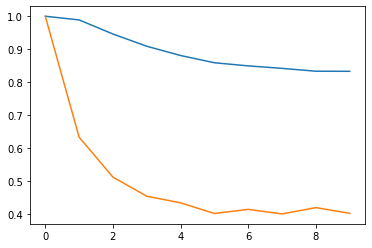

0.3127375
0.16274187996032652


In [ ]:
use_saved_expt = False
if use_saved_expt:
  analysis = Analysis(expt_dir, default_metric="recall_at_k", default_mode="max")
  w2v_params = analysis.get_best_config()
else:
  w2v_params = {
          "min_count": 1,
          "iter": 10,
          "workers": 10,
          "sg": 1,
      }

# Instantiate callback to measurs Recall@K on the validation set after each epoch of training
ratk_logger = RecallAtKLogger(valid, k=10, save_model=True)
# Instantiate callback to compute Word2Vec's training loss on the training set after each epoch of training
loss_logger = LossLogger()
# Train Word2Vec model and retrieve trained embeddings
embeddings = train_w2v(train, w2v_params, [ratk_logger, loss_logger])

# Save results
pickle.dump(ratk_logger.recall_scores, open(os.path.join("/content", f"recall@k_per_epoch.pkl"), "wb"))
pickle.dump(loss_logger.training_loss, open(os.path.join("/content", f"trainloss_per_epoch.pkl"), "wb"))

# Save trained embeddings
embeddings.save(os.path.join("/content", f"embeddings.wv"))

# Visualize metrics as a function of epoch
plt.plot(np.array(ratk_logger.recall_scores)/np.max(ratk_logger.recall_scores))
plt.plot(np.array(loss_logger.training_loss)/np.max(loss_logger.training_loss))
plt.show()

# Print results on the test set
print(recall_at_k(test, embeddings, k=10))
print(mrr_at_k(test, embeddings, k=10))

In [ ]:
!zip -r /content/Sample_10_epochs/results.zip /content/Sample_10_epochs

  adding: content/Sample_10_epochs/ (stored 0%)
  adding: content/Sample_10_epochs/recall@k_per_epoch.pkl (deflated 2%)
  adding: content/Sample_10_epochs/contentw2v_0.model (deflated 30%)
  adding: content/Sample_10_epochs/embeddings.wv (deflated 29%)
  adding: content/Sample_10_epochs/trainloss_per_epoch.pkl (deflated 34%)
